# Synthetic data details
We sample $N=100$ from four models. The one-dimensional time domain is fixed to $[0,1]$
1. Early: Branching model with early branching $trueB=0.1$.
1. Med: Branching model with medium branching $trueB=0.5$.
1. Late: Branching model with late branching $trueB=0.8$.
1. Int: Integrated GP with no branching. This is simple Gaussian process regression.

We compare a full model training on the entire dataset and the a sparse GP on $M=21$ points. Note that for the sparse GP the actual size of the covariance is $M\times 3$ as we have one entry per possible function.

No hyperparameter estimation is taking place except the likelihood Gaussian variance as the kernel hyperparameters are fixed to their true values.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats as ss
import pickle
strDataDir = '/home/mqbssaby/transfer/syn'  # where data lives
numExperiments = 100  # number of experiments

In [2]:
def plotBranchModel(B, pt, Y, ttestl, mul, varl, Phi, figsizeIn=(5, 5), lw=3., fs=10, labels=None,
                    fPlotPhi=True, fPlotVar=False, ax=None):
    ''' Plotting code that does not require access to the model but takes as input predictions. '''
    if(ax is None):
        fig = plt.figure(figsize=figsizeIn)
        ax = fig.gca()
    else:
        fig = plt.gcf()
    d = 0  # constraint code to be 1D for now
    for f in range(3):
        mu = mul[f]
        var = varl[f]
        ttest = ttestl[f]
        mean, = ax.plot(ttest, mu[:, d], linewidth=lw)
        col = mean.get_color()
        if(fPlotVar):
            ax.plot(ttest.flatten(), mu[:, d] + 2 * np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
            ax.plot(ttest, mu[:, d] - 2 * np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
    v = ax.axis()
    ax.plot([B, B], v[-2:], '-m', linewidth=lw)
    # Plot Phi or labels
    if(fPlotPhi):
        gp_num = 1  # can be 0,1,2 - Plot against this
        PhiColor = ax.scatter(pt, Y[:, d], c=Phi[:, gp_num], vmin=0., vmax=1, s=40)
        # plt.colorbar(PhiColor, label='GP {} assignment probability'.format(gp_num))
    return fig

def plotScatterMeanRanking(meanRank, title, Btry):
    ''' Function to do bubble plot of rank. Size of marker proportional to error'''
    traceCell= list()
    layout = go.Layout(showlegend=True, title='Mean ranking %s' % title,
                       annotations=list())
    for r in range(meanRank.shape[0]):
        traceCell.append(go.Scatter(
            x = Btry + 0.15*np.random.rand(len(Btry)),
            y = meanRank[r, :],
            mode='markers',
            name = r,
            text = r,
            marker={'size': 10*np.abs(meanRank[r, :] - np.array([1,2,3,4]))}  # make size prop to error
            ))
    fig = go.Figure(data=traceCell, layout=layout)
    iplot(fig, filename='MeanRank%s' % title)

In [3]:
def GetRunData(fSparse, nrun, nTrueB, fPrint=True):
    assert nTrueB >=0 and nTrueB <=3, 'Should be 0 to 3'
    rallDescr = ['Full', 'Sparse']
    fullNamel = ['%s/runArrayJob_%s' % (strDataDir, rallDescr[0]),
                 '%s/runArrayJob_%s' % (strDataDir, rallDescr[1])]
    strfile = fullNamel[fSparse]+str(nrun)+'.p'
    if(fPrint):
        print('Open files %s' % strfile)
    r = pickle.load(open(strfile, "rb"))
    # Get objective functions and GP fits
    BgridSearch = r['BgridSearch']
    Btry = r['Btry']
    Btry[-1] = 1  # integrate GP as 1
    obj = r['mlist'][nTrueB]['obj']
    objInt = r['mlist'][nTrueB]['objInt']
    gridSearchData = r['mlist'][nTrueB]
    gridSearchGPs = r['mlist'][nTrueB]['mlocallist']
    assert len(obj) == len(gridSearchGPs), 'One GP per grid search pt'
    iMin = np.argmin(obj)  # we could also plot other GPs on the grid
    gpPlot = gridSearchGPs[iMin]  
    return obj, gridSearchData, gridSearchGPs, BgridSearch, Btry, objInt

In [4]:
def GetPosteriorB(fSparse, fPrint=False):
    '''
    Return posterior on B for each experiment
    '''
    _, _, _, BgridSearch, Btry,_ = GetRunData(fSparse, 1, 0, False)  # Get Bgrid and Btry. Experiments is 1-based
    posteriorB = np.zeros((numExperiments, len(Btry), len(BgridSearch))) # nexp X trueB X B grid src
    posteriorB[:] = np.nan    
    for ns in range(1, numExperiments+1):        
        for ib, b in enumerate(Btry):
            obj, gridSearchData, gridSearchGPs, BgridSearchI, BtryI,_ = GetRunData(fSparse, ns, ib, False)
            assert set(BtryI) == set(Btry), 'Btry ust be the same or we are loading wrong file.'
            assert set(BgridSearchI) == set(BgridSearch), 'BgridSearch must be the same or we are loading wrong file.'
            # for each trueB calculate posterior over grid
            # ... in a numerically stable way
            o = -obj
            pn = np.exp(o - np.max(o))
            p = pn/pn.sum()
            assert np.any(~np.isnan(p)), 'Nans in p! %s' % str(p)
            assert np.any(~np.isinf(p)), 'Infinities in p! %s' % str(p)
            posteriorB[ns-1, ib, :] = p
            if(fPrint):
                print('%g:B=%s probs=' % (ns, b), np.round(p, 2))
    return posteriorB, Btry, BgridSearch
posteriorBFull, Btry, BgridSearch = GetPosteriorB(False, False)
posteriorBSparse, Btry, BgridSearch = GetPosteriorB(True, False)

In [5]:
def GetMeanRank(posteriorB, Btry, BgridSearch):
    '''
    Return mean rank for synthetic experiment
    '''
    numExps = posteriorB.shape[0]
    assert numExps == numExperiments
    numTrueB = posteriorB.shape[1]
    assert numTrueB == len(Btry)
    numGrid = posteriorB.shape[2]
    assert numGrid == len(BgridSearch)
    # for each experiment
    meanRank = np.zeros((numExps, numTrueB))  # nexp X num true B
    meanRank[:] = np.nan
    nMC = 100  # do Monte Carlo estimation of rank
    ranks = np.zeros((numExps, nMC, numTrueB))  # rank
    ranks[:] = np.nan
    samples = np.zeros((numExps, nMC, numTrueB))  # samples from Branching posterior
    samples[:] = np.nan
    for ns in range(numExps):
        for m in range(nMC):
            for ib, b in enumerate(Btry):
                # Sample from posterior for given branch pt
                samples[ns, m, ib] = np.random.choice(BgridSearch, p=posteriorB[ns, ib, :])
            # Rank each branch point
            ranks[ns, m, :] = ss.rankdata(samples[ns, m, :])  # only calculate rank if no errors
        # Calculate mean rank
        meanRank[ns, :] = np.mean(ranks[ns, :, :], 0)
        assert np.all(~np.isnan(meanRank[ns, :]))
    return meanRank, ranks, samples
meanRankFull, ranksFull, samplesFull = GetMeanRank(posteriorBFull, Btry, BgridSearch)
meanRankSparse, ranksSparse, samplesSparse = GetMeanRank(posteriorBSparse, Btry, BgridSearch)

# Box-whisker plot of mean rankings
1. We see the sparse GP with only 21 points doing better than the full GP. The latter identifies the late branching points sooner than the former.

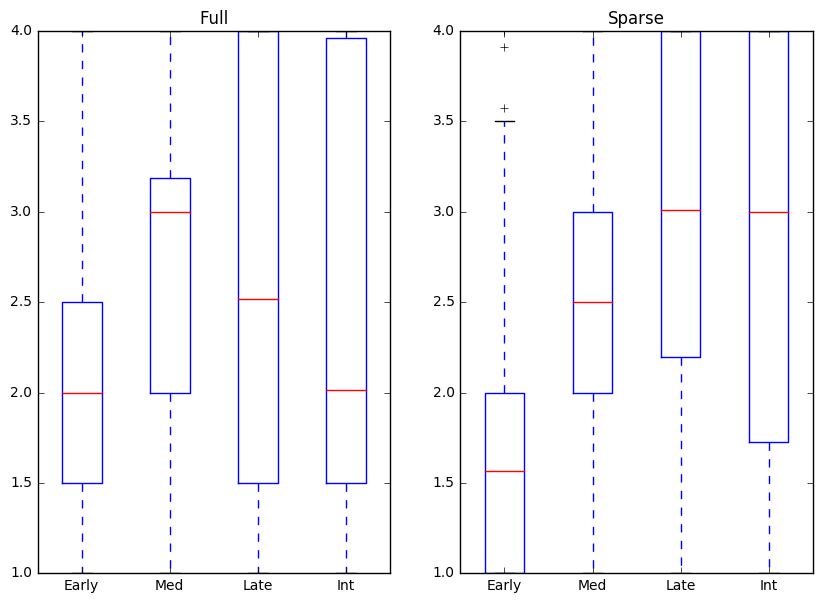

In [6]:
f, axarr = plt.subplots(1, 2, figsize=(10, 7))
ax = axarr.flatten()
ax[0].boxplot(meanRankFull, labels=['Early', 'Med', 'Late', 'Int'])
ax[0].set_title('Full')
ax[1].boxplot(meanRankSparse, labels=['Early', 'Med', 'Late', 'Int'])
ax[1].set_title('Sparse')

In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
    
def plotBranchingModel(fSparse = False, nrun = 98, showAllB=False, nTrueB = 0):
    rallDescr = ['Full', 'Sparse']
    if(fSparse):
        rank = meanRankSparse
        posteriorB = posteriorBSparse
    else:
        rank = meanRankFull
        posteriorB = posteriorBFull
    bt = [nTrueB]
    if(showAllB):
        bt = np.arange(0, 4)
    f, ax = plt.subplots(len(bt), 3, figsize=(12, 12))
    ax = np.reshape(ax, (len(bt), 3))
    for b in bt:
        obj, gridSearchData, gridSearchGPs, BgridSearch, Btry,_ = GetRunData(fSparse, nrun, b)
        assert len(obj) == len(gridSearchGPs), 'One GP per grid search pt'
        iMin = np.argmin(obj)  # we could also plot other GPs on the grid
        gpPlot = gridSearchGPs[iMin]    
        # Plot GP
        _=plotBranchModel(gpPlot['candidateB'], gridSearchData['pt'], gridSearchData['Y'],
                          gpPlot['ttestl'], gpPlot['mul'], gpPlot['varl'],
                          gpPlot['Phi'], fPlotPhi=True, fPlotVar=True, ax=ax[b, 0])
        
        ax[b, 0].set_title('TrueB=%s b=%g NLL=%.1f NULL=%.1f' % (gridSearchData['trueBStr'],
                                                            gpPlot['candidateB'],
                                                            gpPlot['obj'],
                                                            gridSearchData['objInt']))
        ax[b, 1].set_title('objective function')
        ax[b, 1].plot(BgridSearch, obj, '-b')
        ax[b, 1].scatter(BgridSearch[iMin], obj[iMin], s=10)
        ax[b, 2].bar(BgridSearch, posteriorB[nrun-1, b, :], 0.05)  # experiments are 1-based
        ax[b, 2].set_title('posterior')
    
    f, ax = plt.subplots(1, figsize=(3, 3))    
    ax.scatter(Btry, rank[nrun-1, :], s=100)  # experiments are 1-based
    ax.set_title('mean rank')
    print('%s:%g: Mean rank\n' % (rallDescr[fSparse], nrun), rank[nrun-1, :])  # '\nposterior\n',np.round(posteriorB[nrun-1, nTrueB, :], 2)

#_=interact(plotBranchingModel, fSparse=False, nrun=(1, 100),showAllB=True, nTrueB=(0, 3))

# Sparse GP performance

In [8]:
s = np.hstack([np.arange(1, meanRankSparse.shape[0]+1)[:,None], meanRankSparse])  # runs are 1-based
# s = np.sort(s, order=np.arange(1,4))
a = s[s[:,1].argsort(),]
print('Best runs')
print(a[:5, :])
print('Worst runs')
print(a[-5:, :])

Best runs
[[ 46.      1.      2.      3.185   3.815]
 [ 76.      1.      2.      3.83    3.17 ]
 [ 26.      1.      2.43    3.975   2.595]
 [ 28.      1.      3.      4.      2.   ]
 [ 75.      1.      3.      4.      2.   ]]
Worst runs
[[ 50.      3.495   1.      3.505   2.   ]
 [ 73.      3.5     1.5     1.5     3.5  ]
 [ 97.      3.575   3.165   2.155   1.105]
 [ 77.      3.91    2.32    1.83    1.94 ]
 [  5.      4.      1.5     3.      1.5  ]]


### Bad ranking
1. The sampled data for the early point has not discernible braching point early on. A difficult case.
2. The medium branching point (TrueB=0.5) is not correctly identified even though it's easy. We see the objective function surface is nearly bimodal at t=0.0 and t=0.5. The posterior though is not - *is this a problem with our posterior calculation?* - see GetPosteriorB code.
3. The late branching point (TrueB=0.8) again is incorrectly identified as being early on (b=0.1). *We do not see a local minimum at the true value b=0.8. Is this because of sparse GP having too few points (21 per function (3))? *
4. For the sample from a single GP, the earliest point is identified as branching. The NULL model has the second lower negative log likelihood (-172) whereas the branching model has the highest neg log likelihood (~6000). Do we just compute a simple likelihood ratio given the vastly different scales here? Or simple rank outputs in terms of the integrated GP likelihood - the worse the fit the more likely this is branching?

Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse5.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse5.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse5.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse5.p
Sparse:5: Mean rank
 [ 4.   1.5  3.   1.5]


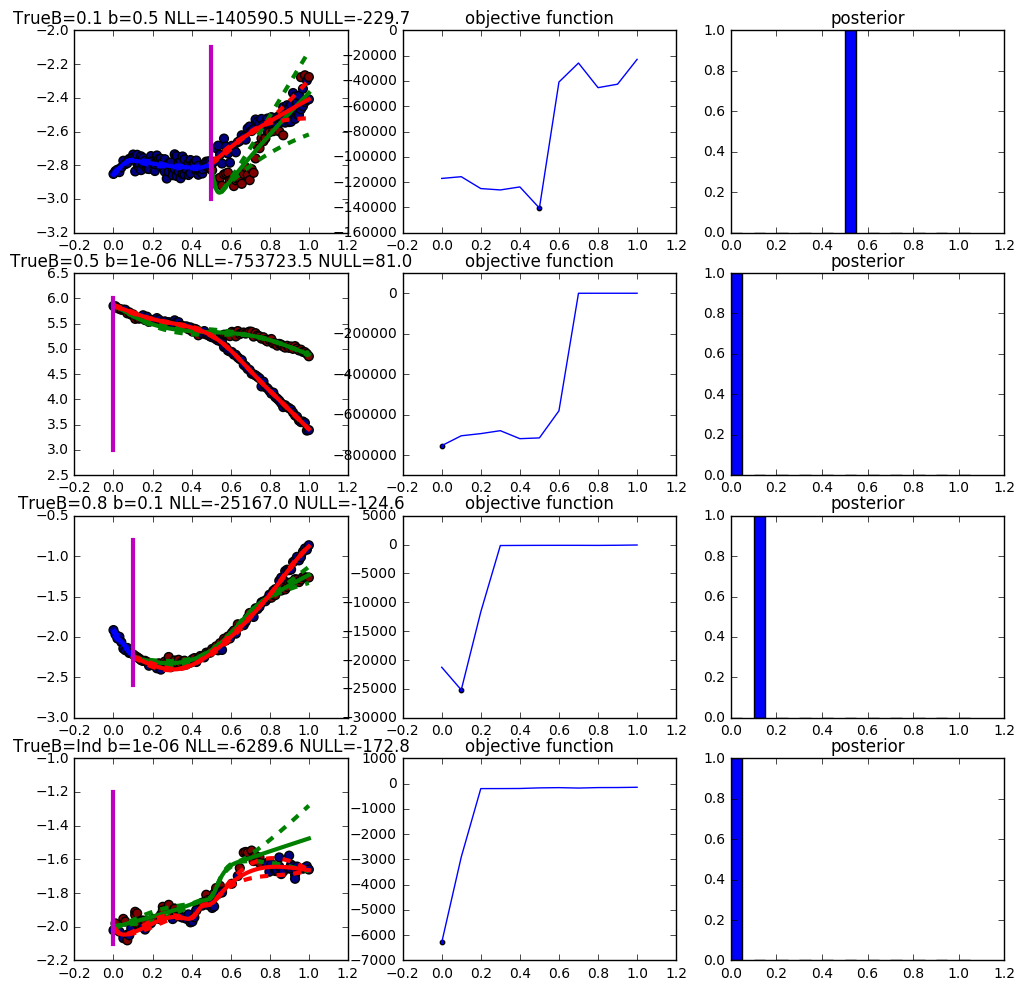

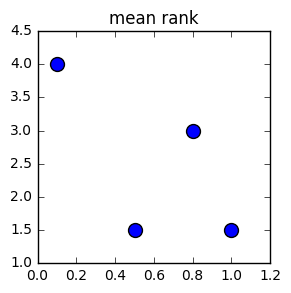

In [9]:
plotBranchingModel(fSparse = True, nrun = 5, showAllB=True)

### A good ranking
1. Note than for trueB=0.5 we identify 0.2 as the branching location. Agaun we see a multimodal posterior in the objective but the the posterior due to the log scale.

Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse46.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse46.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse46.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Sparse46.p
Sparse:46: Mean rank
 [ 1.     2.     3.185  3.815]


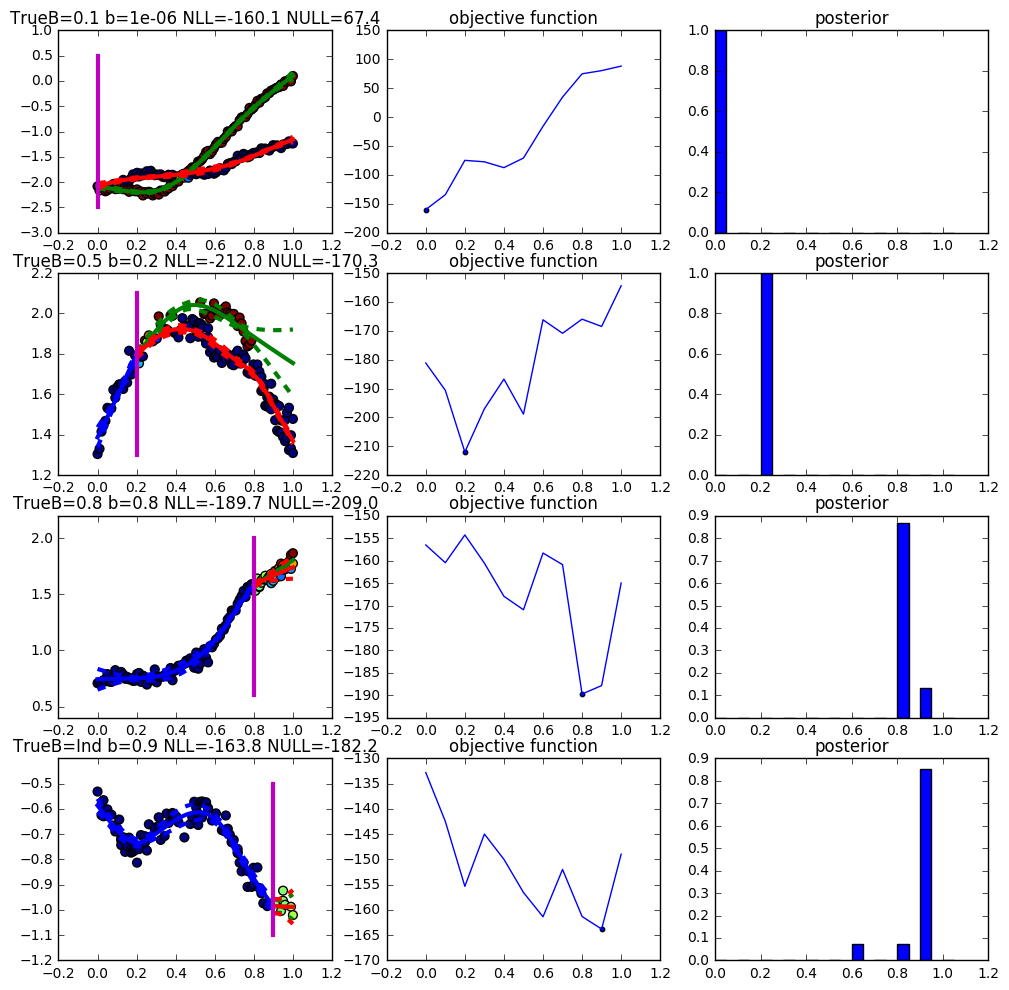

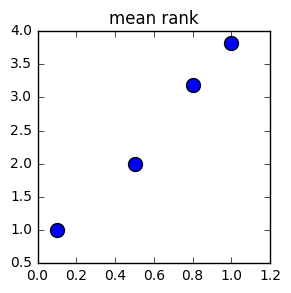

In [10]:
plotBranchingModel(fSparse = True, nrun = 46, showAllB=True)

# Full GP performance

In [11]:
s = np.hstack([np.arange(1, meanRankFull.shape[0]+1)[:,None], meanRankFull])  # runs are 1-based
# s = np.sort(s, order=np.arange(1,4))
a = s[s[:,1].argsort(),]
print('Best runs')
print(a[:5, :])
print('Worst runs')
print(a[-5:, :])


Best runs
[[ 83.     1.     2.     3.5    3.5 ]
 [ 32.     1.     2.     3.5    3.5 ]
 [ 34.     1.     2.     3.     4.  ]
 [ 21.     1.     3.     2.     4.  ]
 [ 20.     1.     2.     3.02   3.98]]
Worst runs
[[ 63.   4.   2.   2.   2.]
 [ 88.   4.   2.   2.   2.]
 [ 58.   4.   2.   2.   2.]
 [  3.   4.   2.   2.   2.]
 [ 50.   4.   2.   2.   2.]]


# A good ranking

Open files /home/mqbssaby/transfer/syn/runArrayJob_Full83.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Full83.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Full83.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Full83.p
Full:83: Mean rank
 [ 1.   2.   3.5  3.5]


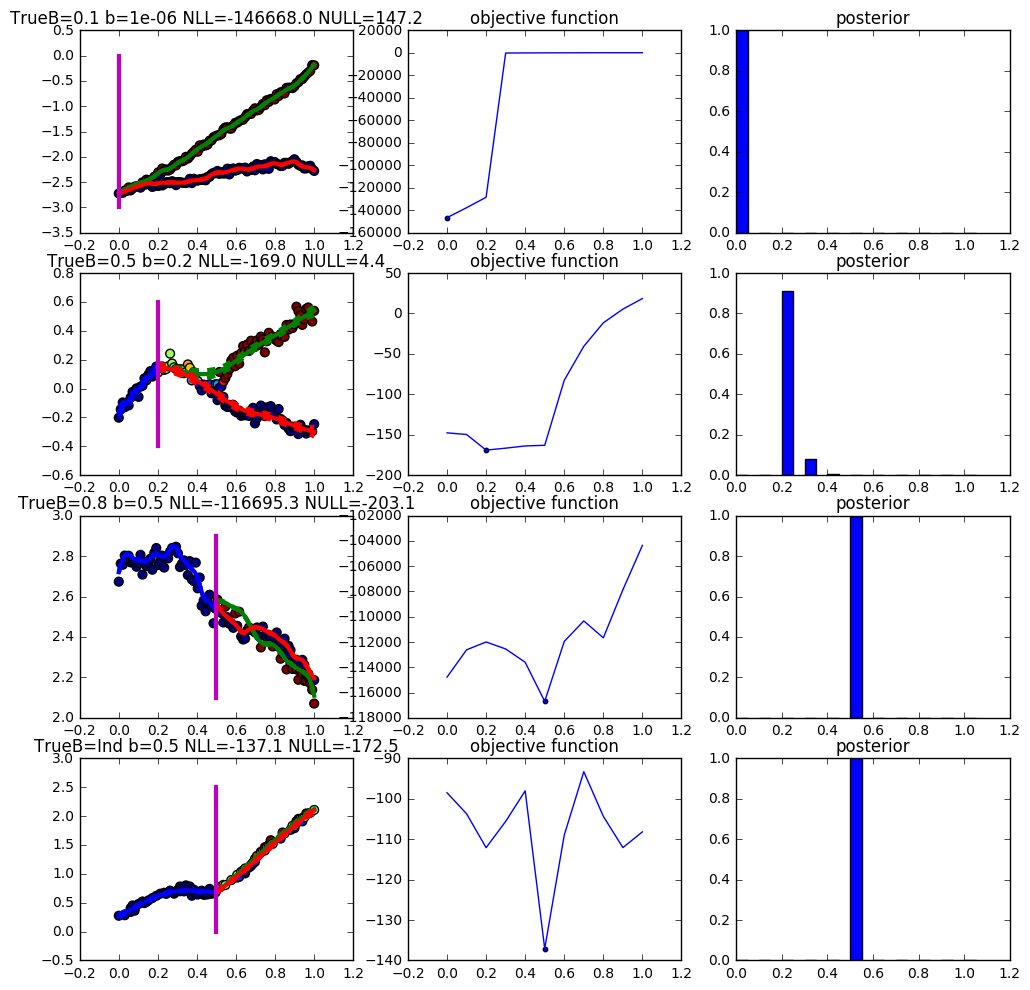

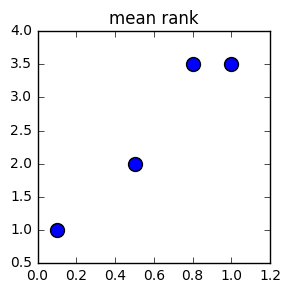

In [12]:
plotBranchingModel(fSparse = False, nrun = 83, showAllB=True)

# A bad ranking
1. The early branching sample (TrueB=0.1) is correctly identified; however all other runs are incorrectly identified as branching early on (b=0).
1. The late branching sample show no evidence of branching and in fact has the highest likelihood for the integrated GP.

Open files /home/mqbssaby/transfer/syn/runArrayJob_Full50.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Full50.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Full50.p
Open files /home/mqbssaby/transfer/syn/runArrayJob_Full50.p
Full:50: Mean rank
 [ 4.  2.  2.  2.]


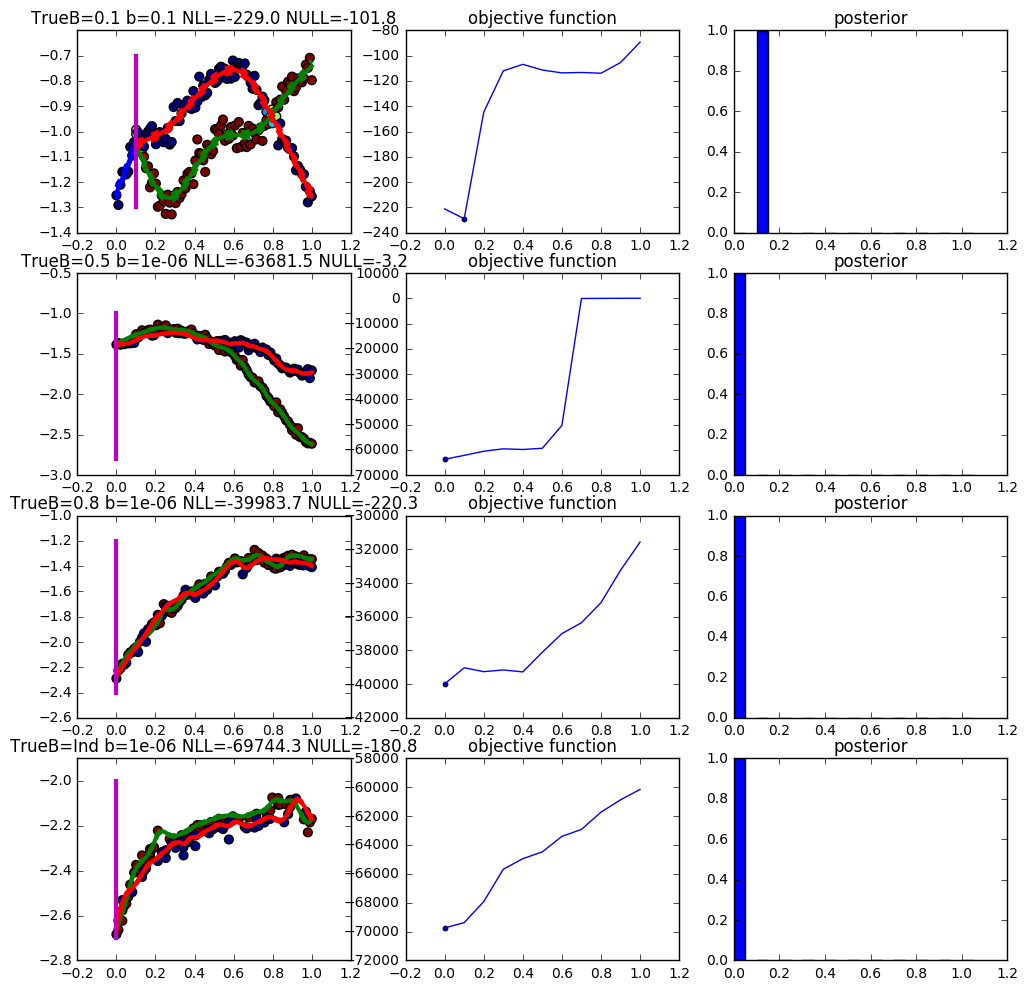

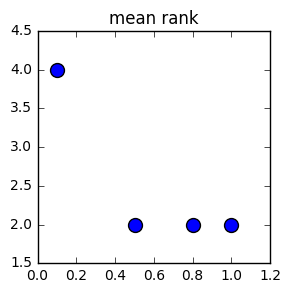

In [13]:
plotBranchingModel(fSparse = False, nrun = 50, showAllB=True)

# Ranking of branching vs non-branching
We explore the question above on whether we should use ratio of log likelihood of branching and integrated GP or simply rank the samples by the value of the integrated GP likelihood.
## It seems that just using the likelihood of the integrated GP works best.

In [14]:
def RankBranchingLogRatio(fSparse = True):
    ''' Function to compute the log likehood ratio of best branching model
    vs integrated-single GP model. It also returns the rank for each sample.'''
    loglikRatio = np.zeros((numExperiments, len(Btry)))
    rankRatio = np.zeros((numExperiments, len(Btry)))
    for ns in range(numExperiments):        
        for ib, b in enumerate(Btry):
            obj, _, _, _, _, objInt = GetRunData(fSparse, ns+1, ib, False) # 1 based
            assert obj.size == len(BgridSearch), 'Must have obj value for each candidate'
            nllBest = -np.min(obj)  # get highest likelihood of branching model
            nllInt  = -objInt
            loglikRatio[ns, ib] = nllBest / nllInt
        rankRatio[ns, :] = ss.rankdata(loglikRatio[ns, :])
    return rankRatio, loglikRatio

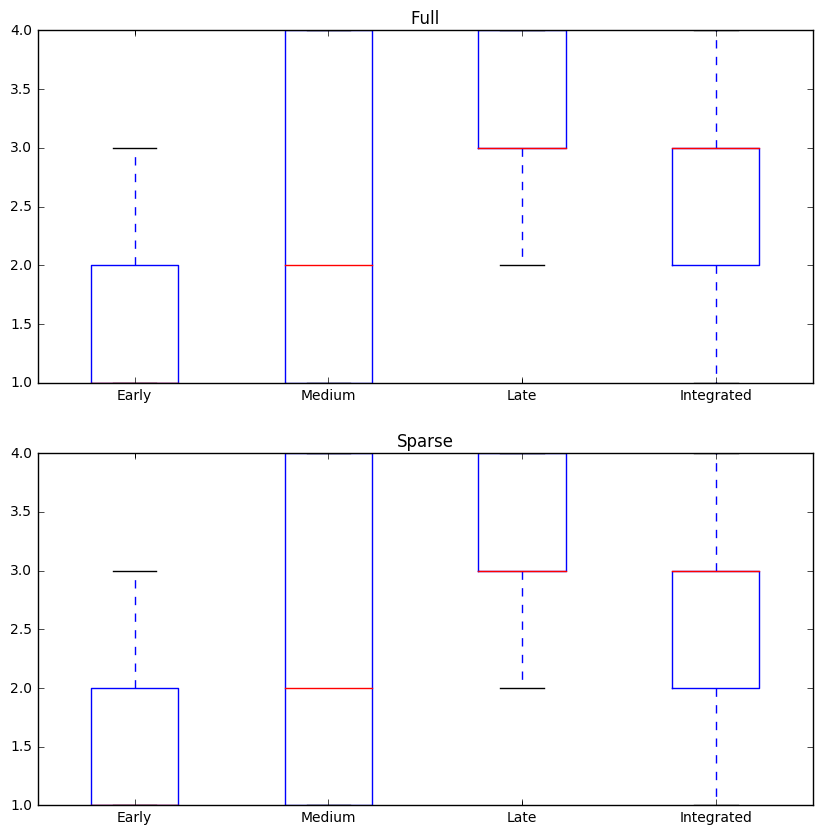

In [15]:
rallDescr = ['Full', 'Sparse']
f, ax = plt.subplots(2, sharex=False, sharey=False, figsize=(10, 10))
for fSparse in range(len(rallDescr)):
    rankRatio, loglikRatio = RankBranchingLogRatio(fSparse=fSparse)
    ax[fSparse].boxplot(rankRatio, labels=['Early', 'Medium', 'Late', 'Integrated'])
    ax[fSparse].set_title(rallDescr[fSparse])

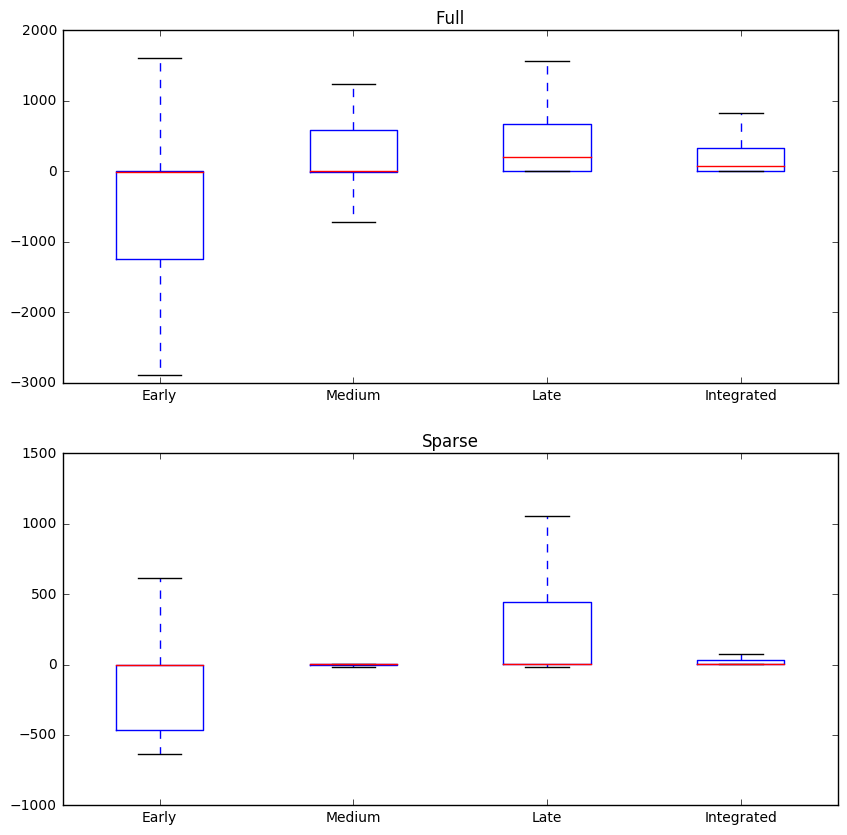

In [16]:
rallDescr = ['Full', 'Sparse']
f, ax = plt.subplots(2, sharex=False, sharey=False, figsize=(10, 10))
for fSparse in range(len(rallDescr)):
    rankRatio, loglikRatio = RankBranchingLogRatio(fSparse=fSparse)
    ax[fSparse].boxplot(loglikRatio, labels=['Early', 'Medium', 'Late', 'Integrated'],
                        showfliers=False)
    ax[fSparse].set_title(rallDescr[fSparse])

In [17]:
def RankBranchingByIntLik(fSparse = True):
    ''' Function to return the log likehood ratio integrated-single GP model.
    It also returns the rank for each sample.'''
    loglikRatio = np.zeros((numExperiments, len(Btry)))
    rankRatio = np.zeros((numExperiments, len(Btry)))
    for ns in range(numExperiments):        
        for ib, b in enumerate(Btry):
            obj, _, _, _, _, objInt = GetRunData(fSparse, ns+1, ib, False) # 1 based
            assert obj.size == len(BgridSearch), 'Must have obj value for each candidate'
            nllInt  = -objInt
            loglikRatio[ns, ib] = nllInt
        rankRatio[ns, :] = ss.rankdata(loglikRatio[ns, :])
    return rankRatio, loglikRatio

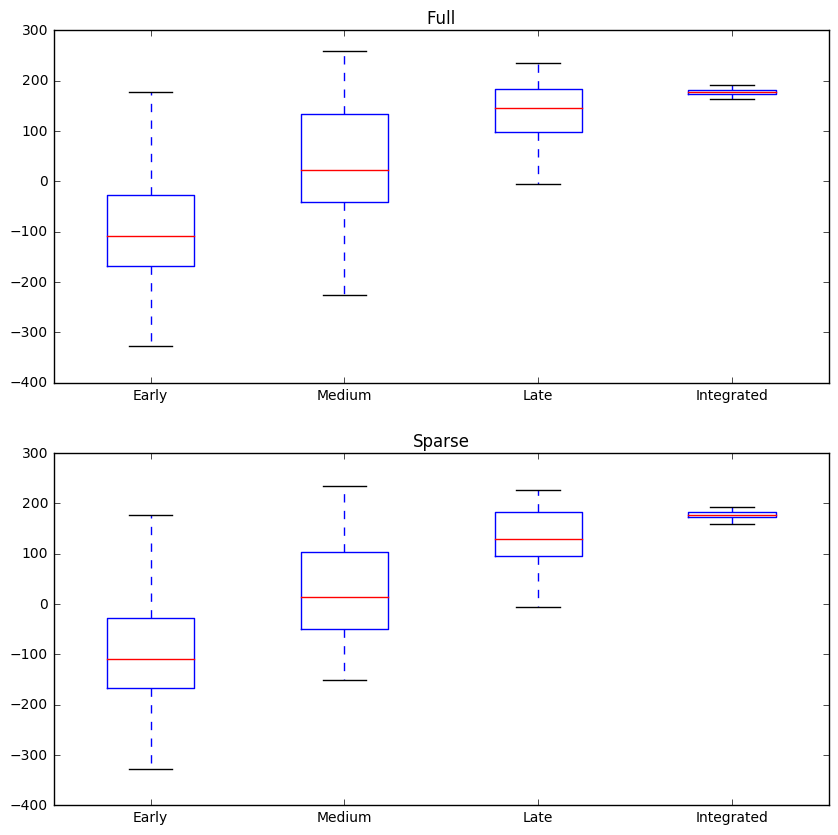

In [18]:
rallDescr = ['Full', 'Sparse']
f, ax = plt.subplots(2, sharex=False, sharey=False, figsize=(10, 10))
for fSparse in range(len(rallDescr)):
    rankRatio, loglikRatio = RankBranchingByIntLik(fSparse=fSparse)
    ax[fSparse].boxplot(loglikRatio, labels=['Early', 'Medium', 'Late', 'Integrated'],
                        showfliers=False)
    ax[fSparse].set_title(rallDescr[fSparse])

# So it seems ranking by just the value of the GPR fit will make the fewer mistakes.